In [513]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import SMOTE

### Data Loading

In [275]:
appl_filenames = ["applicationDNS.csv", "dns_application_2017_1.csv", "dns_application_2017.csv"]
appl_dataset_folder = "datasets/application_data_flow"

bot_filenames = ["init.csv","init2.csv","init3.csv","init4.csv","init5.csv"]
bot_dataset_folder = "datasets/botnet_data_flow"

Load Dataset and Label Malicious and Benign Network Flows

In [276]:
appl_dfs = []
for file in appl_filenames:
    appl_dfs.append(pd.read_csv(f"{appl_dataset_folder}/{file}"))
appl_df = pd.concat(appl_dfs, ignore_index=True)
appl_df['Label'] = 'Benign'
print(f"Number of Benign Flows: {len(appl_df)}")


botnet_dfs = []
for file in bot_filenames:
    botnet_dfs.append(pd.read_csv(f"{bot_dataset_folder}/{file}"))
botnet_df = pd.concat(botnet_dfs, ignore_index=True)

ip_list = ["192.168.50.14","192.168.50.15","192.168.50.16","192.168.50.17","192.168.50.18","192.168.50.30","192.168.50.31", "192.168.50.32","192.168.50.34"]
botnet_df['Label'] = botnet_df['Src IP'].isin(ip_list).apply(lambda x: 'Malicious' if x else 'Normal')
botnet_df = botnet_df[botnet_df['Label']=='Malicious']
print(f"Number of Malicious Flows: {len(botnet_df)}")

df = pd.concat([appl_df, botnet_df], ignore_index=True)

Number of Benign Flows: 76478
Number of Malicious Flows: 539715


### Data Analysis and Visualization

Number of Flows for each Botnet

In [323]:
ip_dict = {
    "192.168.50.14":"Zyklon",
    "192.168.50.15":"Blue",
    "192.168.50.16":"Liphyra",
    "192.168.50.17":"Gaudox",
    "192.168.50.18":"Blackout",
    "192.168.50.30":"Citadel",
    "192.168.50.31":"Citadel2", 
    "192.168.50.32":"BlackEnergy",
    "192.168.50.34":"Zeus"
}

count=0
for ip in ip_dict.keys():
    entries = df[df["Src IP"]==ip]
    count += len(entries)
for ip in ip_dict.keys():
    entries = df[df["Src IP"]==ip]
    print(f"{ip} ({ip_dict[ip]}): {len(entries)} ({len(entries)/count * 100:.2f}%)")

192.168.50.14 (Zyklon): 28823 (5.34%)
192.168.50.15 (Blue): 42554 (7.88%)
192.168.50.16 (Liphyra): 17217 (3.19%)
192.168.50.17 (Gaudox): 132013 (24.46%)
192.168.50.18 (Blackout): 37423 (6.93%)
192.168.50.30 (Citadel): 45218 (8.38%)
192.168.50.31 (Citadel2): 132699 (24.59%)
192.168.50.32 (BlackEnergy): 15831 (2.93%)
192.168.50.34 (Zeus): 87937 (16.29%)
[CV] END .......................................max_depth=30; total time=  11.3s
[CV] END .......................................max_depth=50; total time=  15.3s
[CV] END .......................max_depth=5, n_estimators=50; total time=  59.7s
[CV] END .....................max_depth=10, n_estimators=100; total time= 3.0min
[CV] END .......................................max_depth=30; total time=  16.5s
[CV] END .......................................max_depth=30; total time=  15.4s
[CV] END .......................max_depth=5, n_estimators=50; total time= 1.0min
[CV] END .....................max_depth=10, n_estimators=100; total time= 3.0mi

In [278]:
df.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.50.50-192.168.50.88-64344-53-17,192.168.50.50,64344,192.168.50.88,53,17,13/06/2017 03:58:41 AM,3984697,1,2,...,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
1,192.168.50.255-192.168.50.19-17500-17500-17,192.168.50.19,17500,192.168.50.255,17500,17,13/06/2017 03:59:59 AM,60015400,2,1,...,0,0.0,0.0,0.0,0.0,30007700.0,11807.269032,30016049.0,29999351.0,Benign
2,192.168.50.51-192.168.50.88-57092-53-17,192.168.50.51,57092,192.168.50.88,53,17,13/06/2017 03:59:46 AM,10000499,4,2,...,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
3,192.168.50.51-192.168.50.88-55824-53-17,192.168.50.51,55824,192.168.50.88,53,17,13/06/2017 04:01:04 AM,7998366,4,1,...,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
4,192.168.50.51-192.168.50.88-58882-53-17,192.168.50.51,58882,192.168.50.88,53,17,13/06/2017 03:59:37 AM,10000458,2,2,...,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign


In [279]:
print(len(df[df['Label']=='Benign']))
print(len(df[df['Label']=='Malicious']))

76478
539715


### Data Preprocessing

In [280]:
# remove nan's and inf's
df = df.replace(np.inf, np.nan)
df = df.dropna()

# drop flow id and information about ip addresses as they would directly give information about origin from botnet
df_X = df.drop(columns=["Label", "Flow ID", "Src IP", "Dst IP", "Src Port","Dst Port", "Timestamp"])
df_y = df["Label"]

In [281]:
# One hot encode the protocol column as this column represents the type of protocol (17=>UDP, 6=>TCP)

df_X = pd.get_dummies(df_X, columns=['Protocol'])
df_X

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Protocol_0,Protocol_6,Protocol_17
0,3984697,1,2,37.0,74.0,37.0,37.0,37.0,0.0,37.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,False,True
1,60015400,2,1,268.0,134.0,134.0,134.0,134.0,0.0,134.0,...,0.0,0.0,0.0,30007700.0,11807.269032,30016049.0,29999351.0,False,False,True
2,10000499,4,2,168.0,84.0,42.0,42.0,42.0,0.0,42.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,False,True
3,7998366,4,1,176.0,44.0,44.0,44.0,44.0,0.0,44.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,False,True
4,10000458,2,2,88.0,88.0,44.0,44.0,44.0,0.0,44.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616188,10000548,2,2,76.0,76.0,38.0,38.0,38.0,0.0,38.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,False,True
616189,223,0,2,0.0,152.0,0.0,0.0,0.0,0.0,118.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,False,True
616190,10000518,4,2,128.0,64.0,32.0,32.0,32.0,0.0,32.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,False,True
616191,6996279,3,2,114.0,76.0,38.0,38.0,38.0,0.0,38.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,False,True


In [282]:
# Normalize data (not for decision tree and random forest)
scaler = StandardScaler()
df_X_scaled = scaler.fit_transform(df_X[df_X.columns[:-3]])

df_X_scaled = pd.DataFrame(df_X_scaled, columns=df_X.columns[:-3])
df_X_scaled[df_X.columns[-3:]] = df_X[df_X.columns[-3:]]
df_X_scaled.head()

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Protocol_0,Protocol_6,Protocol_17
0,-0.197223,-0.178273,0.061675,-0.256793,-0.012647,0.453814,0.466711,0.464425,-0.046834,-0.276854,...,-0.061106,-0.14495,-0.16014,-0.205001,-0.088995,-0.207219,-0.195185,False,False,True
1,2.427070,0.098283,-0.459456,1.086011,-0.006000,3.311558,3.383699,3.373460,-0.046834,0.047440,...,-0.061106,-0.14495,-0.16014,2.993699,-0.085403,2.569671,3.202846,False,False,True
2,0.084537,0.651396,0.061675,0.504711,-0.011539,0.601121,0.617071,0.614375,-0.046834,-0.260138,...,-0.061106,-0.14495,-0.16014,-0.205001,-0.088995,-0.207219,-0.195185,False,False,True
3,-0.009236,0.651396,-0.459456,0.551215,-0.015971,0.660043,0.677215,0.674355,-0.046834,-0.253452,...,-0.061106,-0.14495,-0.16014,-0.205001,-0.088995,-0.207219,-0.195185,False,False,True
4,0.084535,0.098283,0.061675,0.039670,-0.011096,0.660043,0.677215,0.674355,-0.046834,-0.253452,...,-0.061106,-0.14495,-0.16014,-0.205001,-0.088995,-0.207219,-0.195185,False,False,True


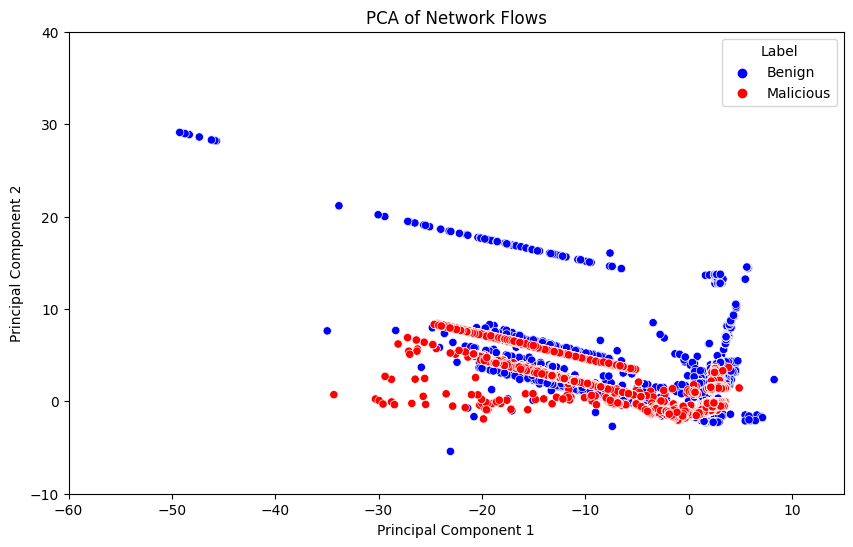

In [520]:
## PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_X_scaled)

# Create a new DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Label']=df['Label']

plt.figure(figsize=(10, 6))
sb.scatterplot(x='PC1', y='PC2', hue='Label', data=pca_df, palette={'Benign': 'blue', 'Malicious': 'red'})
plt.title('PCA of Network Flows')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.xlim((-60,15))
plt.ylim((-10,40))
plt.legend(title='Label', loc='upper right')
plt.show()

### Train Decision Tree

In [73]:
def train_decision_tree(X_train, X_test, y_train, y_test, depth):
    unique_labels = ["Normal", "Malicious"] #set them manually, so that confusion matrix always shows all possible labels

    dt = DecisionTreeClassifier(max_depth=depth, random_state=4)

    dt.fit(X_train, y_train)

    ##Plot and Save Decision Tree
    #plt.figure(figsize=(80, 30))
    #plot_tree(dt, filled=True,fontsize=10, feature_names=list(X_train.columns))
    #plt.savefig('decision_tree.png', bbox_inches='tight')

    #Compute train error
    y_train_pred = dt.predict(X_train)
    print(f"Train Accuracy = {accuracy_score(y_train, y_train_pred)}")
    #print(classification_report(y_train, y_train_pred, labels=unique_labels))
    
    #Compute test error and display metrics
    y_test_pred = dt.predict(X_test)
    print(f"Test Accuracy = {accuracy_score(y_test, y_test_pred)}")
    #print(classification_report(y_test, y_test_pred, labels=unique_labels))

    cm = confusion_matrix(y_test, y_test_pred, labels=unique_labels)    
    plt.figure()
    ax = sb.heatmap(cm, annot=True, cmap="Blues", fmt='d')
    ax.set_title("Test Confusion Matrix\n\n")
    ax.set_xlabel("\nPredicted Values")
    ax.set_ylabel("Actual Values ")
    ax.xaxis.set_ticklabels(unique_labels)
    ax.yaxis.set_ticklabels(unique_labels)
    plt.show()

In [84]:
# Cross-Validation

clf = DecisionTreeClassifier(max_depth=15, random_state=4)

scores = cross_val_score(clf, df_X, df_y, cv=5)

scores

array([0.89575416, 0.98649874, 0.95995188, 0.93167807, 0.95128975])

Train Accuracy = 0.8605558549902749
Test Accuracy = 0.8596381443048434


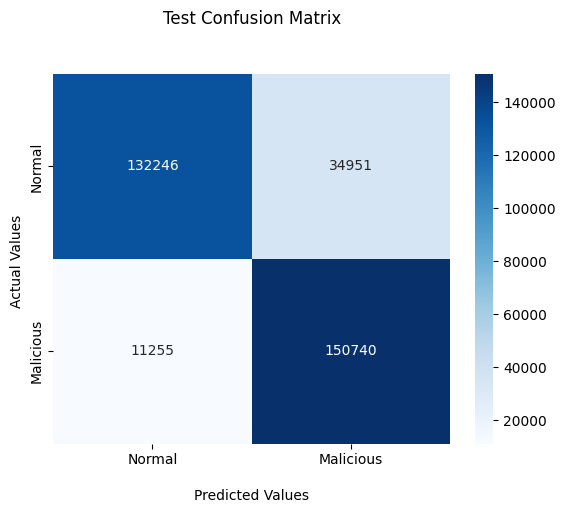

Train Accuracy = 0.9607415045162567
Test Accuracy = 0.9574442878320251


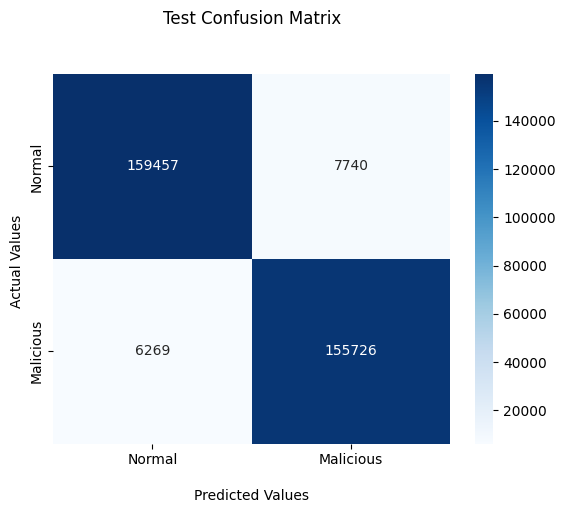

Train Accuracy = 0.9800120815399798
Test Accuracy = 0.951605749835962


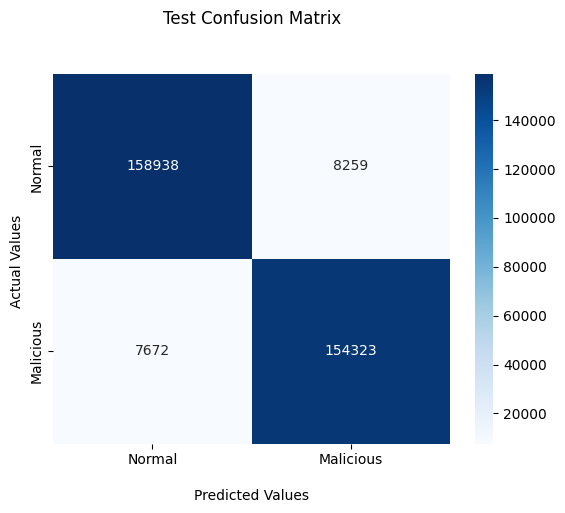

In [74]:
for depth in [5,15,30]:
    train_decision_tree(X_train, X_test, y_train, y_test, depth)

### Train Random Forest

In [75]:
def train_random_forest(X_train, X_test, y_train, y_test, depth, est):
    unique_labels = ["Normal", "Malicious"] #set them manually, so that confusion matrix always shows all possible labels

    dt = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=42)

    dt.fit(X_train, y_train)

    ##Plot and Save Decision Tree
    #plt.figure(figsize=(80, 30))
    #plot_tree(dt, filled=True,fontsize=10, feature_names=list(X_train.columns))
    #plt.savefig('decision_tree.png', bbox_inches='tight')

    #Compute train error
    y_train_pred = dt.predict(X_train)
    print(f"Train Accuracy = {accuracy_score(y_train, y_train_pred)}")
    #print(classification_report(y_train, y_train_pred, labels=unique_labels))
    
    #Compute test error and display metrics
    y_test_pred = dt.predict(X_test)
    print(f"Test Accuracy = {accuracy_score(y_test, y_test_pred)}")
    #print(classification_report(y_test, y_test_pred, labels=unique_labels))

    cm = confusion_matrix(y_test, y_test_pred, labels=unique_labels)    
    plt.figure()
    ax = sb.heatmap(cm, annot=True, cmap="Blues", fmt='d')
    ax.set_title("Test Confusion Matrix\n\n")
    ax.set_xlabel("\nPredicted Values")
    ax.set_ylabel("Actual Values ")
    ax.xaxis.set_ticklabels(unique_labels)
    ax.yaxis.set_ticklabels(unique_labels)
    plt.show()

In [76]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3)

Train Accuracy = 0.8967002293930328
Test Accuracy = 0.8973942258621108


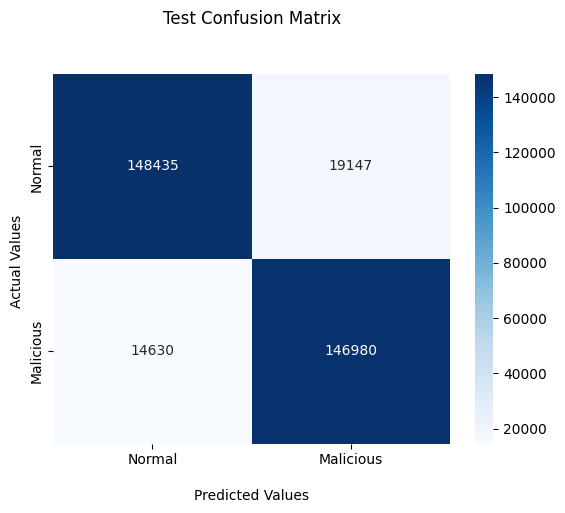

Train Accuracy = 0.9035390580044108
Test Accuracy = 0.9045784830737077


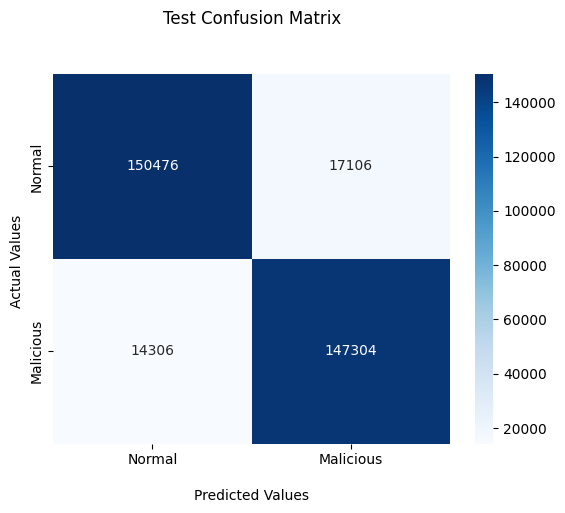

Train Accuracy = 0.9563970973058686
Test Accuracy = 0.9560833799120271


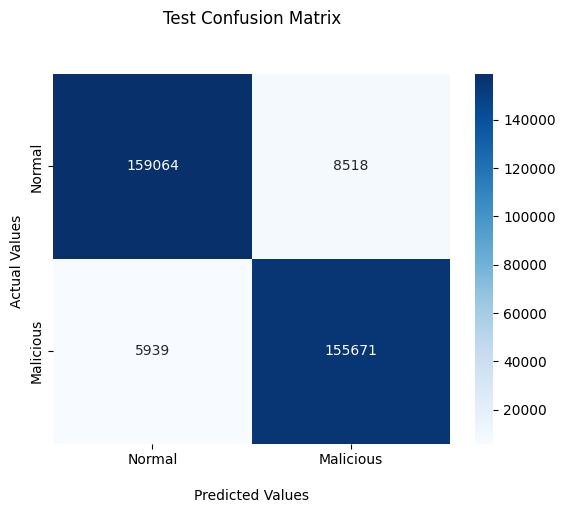

Train Accuracy = 0.9563476254826757
Test Accuracy = 0.9559436438309558


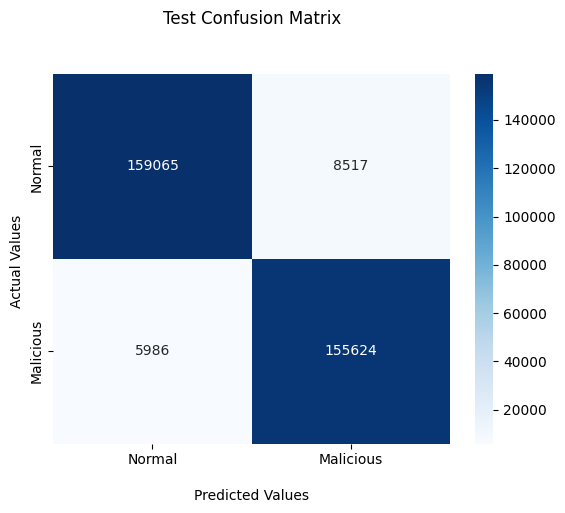

Train Accuracy = 0.982200558771224
Test Accuracy = 0.9574230236457751


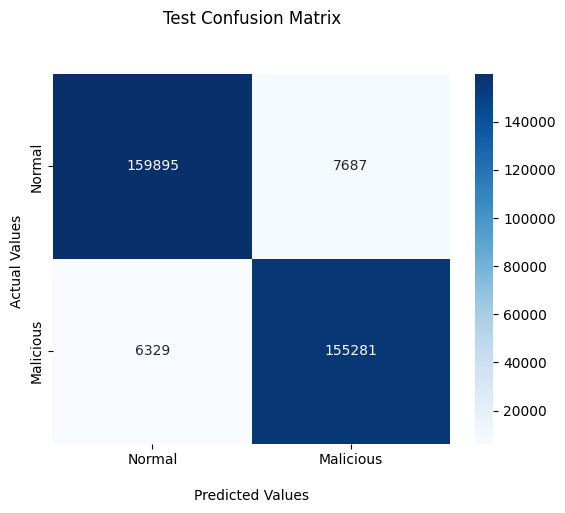

Train Accuracy = 0.982414068745004
Test Accuracy = 0.9577632506257746


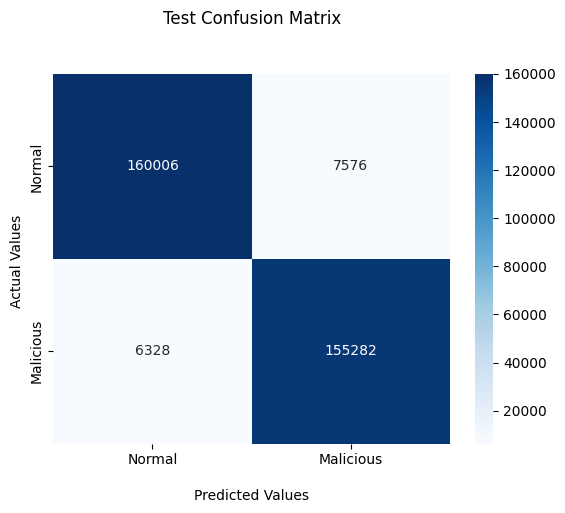

Train Accuracy = 0.9886475184673108
Test Accuracy = 0.9565754939366692


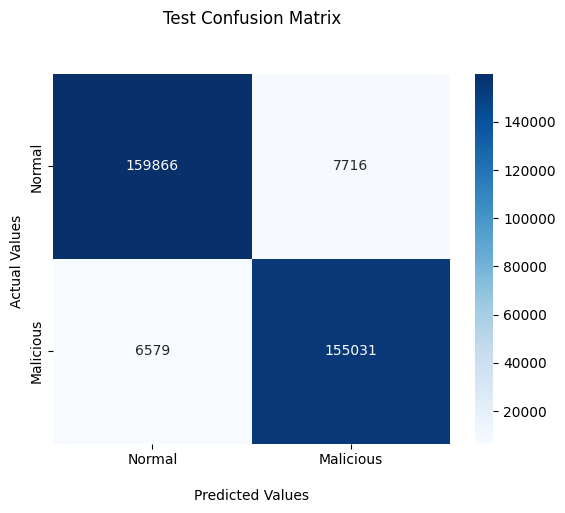

Train Accuracy = 0.9889534626370565
Test Accuracy = 0.956539041045955


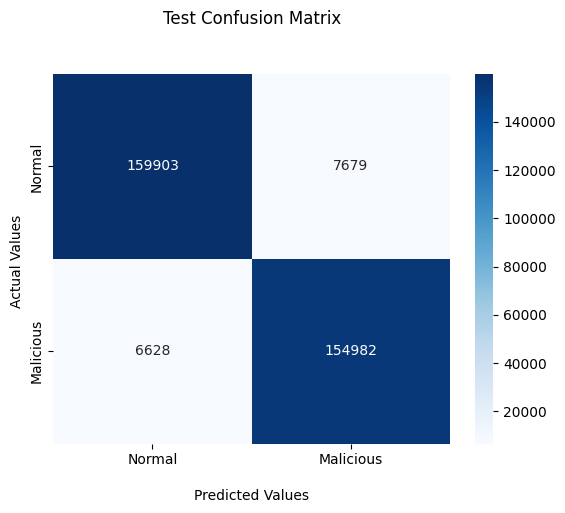

In [89]:
for depth in [5,10,30,50]:
    for est in [50,100]:
        train_random_forest(X_train, X_test, y_train, y_test, depth, est)

## Functions for Grid Search

In [286]:
def perform_grid_search(classifier, param_grid, df_X, df_y, test_size=0.3):
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=test_size)
    
    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
    
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_parameters = grid_search.best_params_
    print("Best Parameters:", best_parameters)
    
    #Compute train error
    y_train_pred = best_model.predict(X_train)
    print(f"Train Accuracy = {accuracy_score(y_train, y_train_pred)}")
    
    #Compute test error and display metrics
    y_test_pred = best_model.predict(X_test)
    print(f"Test Accuracy = {accuracy_score(y_test, y_test_pred)}")
    
    unique_labels = ["Benign", "Malicious"]
    cm = confusion_matrix(y_test, y_test_pred, labels=unique_labels)    
    plt.figure()
    ax = sb.heatmap(cm, annot=True, cmap="Blues", fmt='d')
    ax.set_title("Test Confusion Matrix\n\n")
    ax.set_xlabel("\nPredicted Values")
    ax.set_ylabel("Actual Values ")
    ax.xaxis.set_ticklabels(unique_labels)
    ax.yaxis.set_ticklabels(unique_labels)
    plt.show()

## Grid Search Decision Tree

### Naive Bayes

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {}
Train Accuracy = 0.9353170969200274
Test Accuracy = 0.9354207012950481


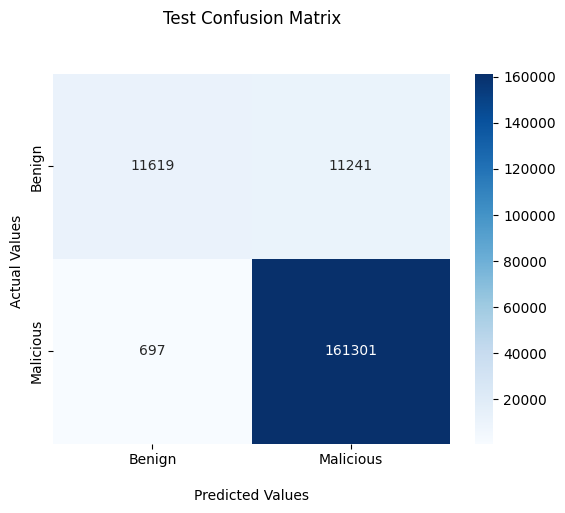

In [475]:
param_grid = {
}

bayes = GaussianNB()

perform_grid_search(bayes, param_grid, df_X_scaled, df_y)

### Logistic Regression

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END .......................................max_iter=500; total time= 1.8min
[CV] END .......................................max_iter=100; total time=  44.6s
[CV] END .......................................max_iter=100; total time=  29.3s
[CV] END .......................................max_iter=500; total time= 1.8min
[CV] END .......................................max_iter=100; total time=  29.4s
[CV] END .......................................max_iter=100; total time=  35.6s


/Users/bernhardzosel/.pyenv/versions/3.9.7/envs/cysecml_397/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bernhardzosel/.pyenv/versions/3.9.7/envs/cysecml_397/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 

[CV] END .......................................max_iter=500; total time= 1.8min
[CV] END .......................................max_iter=500; total time= 1.6min
[CV] END .......................................max_iter=500; total time= 2.9min


/Users/bernhardzosel/.pyenv/versions/3.9.7/envs/cysecml_397/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .......................................max_iter=100; total time=  43.7s
[CV] END .......................................max_iter=500; total time= 1.6min
[CV] END ......................................max_iter=1000; total time= 3.8min
Best Parameters: {'max_iter': 1000}
Train Accuracy = 0.9672991989984583
Test Accuracy = 0.9675480639193327


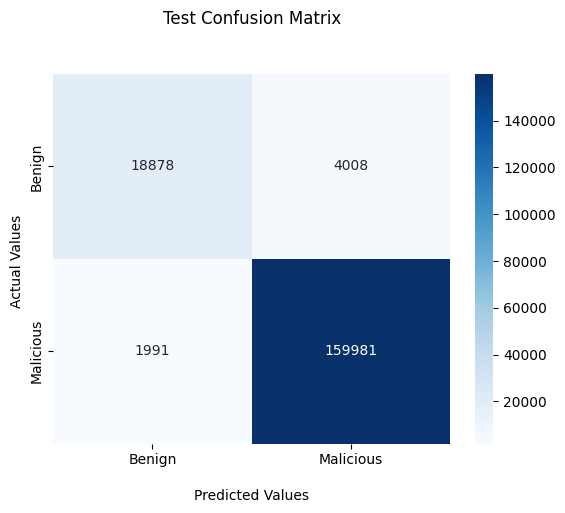

In [294]:
param_grid = {
    'max_iter': [500,1000]
}

log = LogisticRegression()

perform_grid_search(log, param_grid, df_X_scaled, df_y)

### Decision Tree

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters: {'max_depth': 30}
Train Accuracy = 0.999661515991051
Test Accuracy = 0.9928323361715479


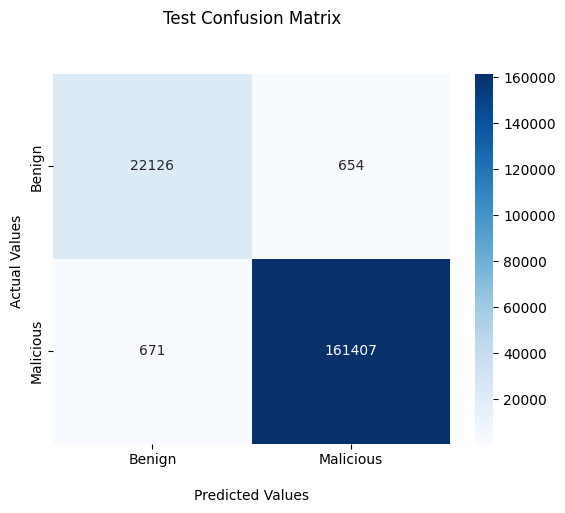

In [287]:
param_grid = {
    'max_depth': [4, 10, 30, 50],
    #'min_samples_split': [2, 5, 10],
    #'min_samples_leaf': [1, 2, 4]
}

dtree = DecisionTreeClassifier()

perform_grid_search(dtree, param_grid, df_X, df_y)

### Random Forest

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ........................................max_depth=4; total time=  14.0s
[CV] END ........................................max_depth=4; total time=   6.9s
[CV] END .......................................max_depth=50; total time=  16.2s
[CV] END ......................max_depth=10, n_estimators=50; total time= 1.5min
[CV] END ......................max_depth=30, n_estimators=50; total time= 1.7min
[CV] END .......................................max_depth=10; total time=  21.2s
[CV] END ........................................max_depth=4; total time=   7.8s
[CV] END .......................................max_depth=50; total time=  15.0s
[CV] END ......................max_depth=10, n_estimators=50; total time= 1.5min
[CV] END ......................max_depth=30, n_estimators=50; total time= 1.7min
[CV] END ........................................max_depth=4; total time=  13.9s
[CV] END .......................................m

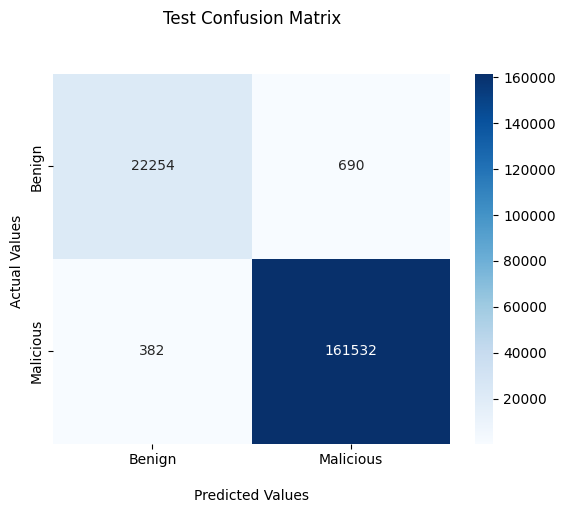

In [289]:
param_grid = {
    'max_depth': [5, 10, 30],
    'n_estimators': [50, 100],
}


rforest = RandomForestClassifier()

perform_grid_search(rforest, param_grid, df_X, df_y)

### Multilayer Perceptron

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant; total time= 5.6min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant; total time= 6.3min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant; total time= 6.6min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant; total time= 6.8min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant; total time=14.5min
Best Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}
Train Accuracy = 0.988018593436656
Test Accuracy = 0.9878988196345303


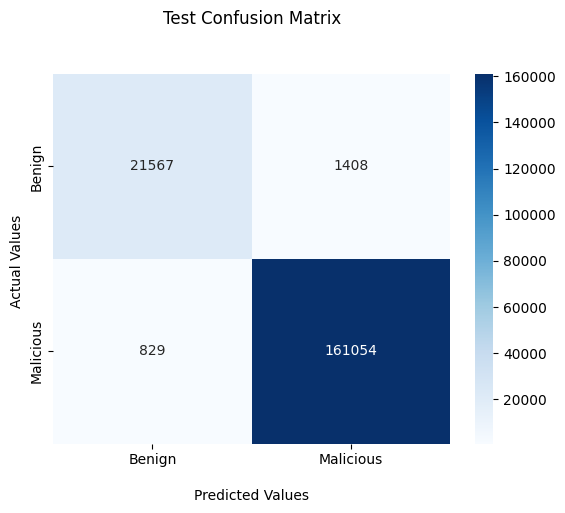

In [297]:
param_grid = {
    'hidden_layer_sizes': [(100,)],#, (50, 50), (50, 30, 20)],
    'activation': ['relu'],#, 'tanh'],
    'alpha': [0.0001],#, 0.01],
    'learning_rate': ['constant']#, 'adaptive']
}

mlp = MLPClassifier()

perform_grid_search(mlp, param_grid, df_X_scaled, df_y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time= 6.8min
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time= 7.7min
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time= 7.9min
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time= 8.9min
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=11.1min
Best Parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive'}
Train Accuracy = 0.9912967878794904
Test Accuracy = 0.9911824211016023


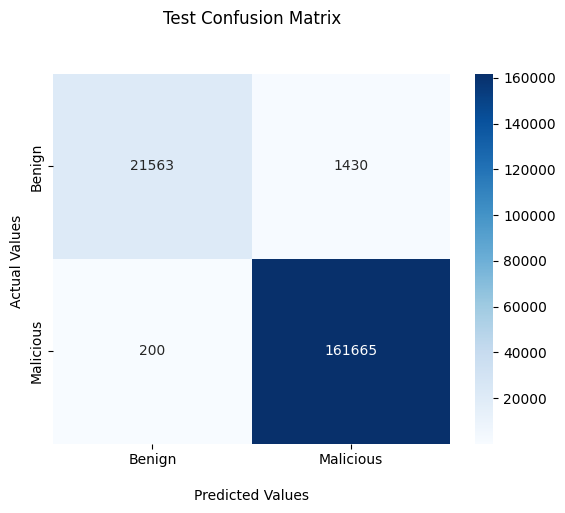

In [298]:
param_grid = {
    'hidden_layer_sizes': [(50, 50)],
    'activation': ['relu'],
    'alpha': [0.001],
    'learning_rate': ['adaptive']
}

mlp = MLPClassifier()

perform_grid_search(mlp, param_grid, df_X_scaled, df_y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time= 5.3min
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time= 9.8min
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=10.7min
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=11.2min
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time=17.5min
Best Parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive'}
Train Accuracy = 0.9900981835464314
Test Accuracy = 0.9896785640870289


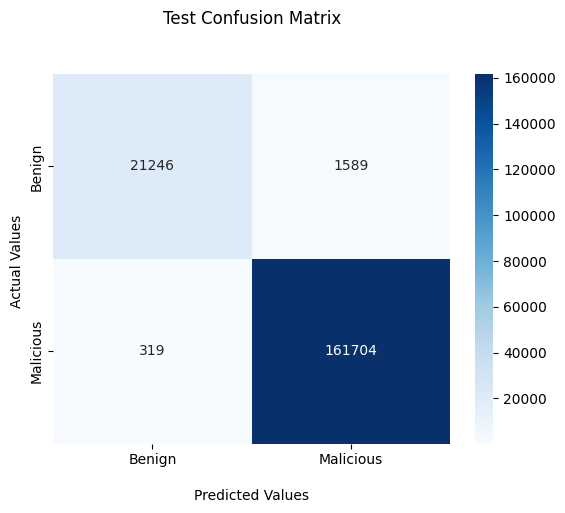

In [521]:
## Decision Tree with pca
pca = PCA(n_components=10)
principal_components = pca.fit_transform(df_X_scaled)

# Create a new DataFrame with the principal components

param_grid = {
    'hidden_layer_sizes': [(50, 50)],
    'activation': ['relu'],
    'alpha': [0.001],
    'learning_rate': ['adaptive']
}

mlp = MLPClassifier()

perform_grid_search(mlp, param_grid, principal_components, df_y)

# Multi-Class Classifier

In [525]:
ip_list = {
    "192.168.50.14":"Zyklon",
    "192.168.50.15":"Blue",
    "192.168.50.16":"Liphyra",
    "192.168.50.17":"Gaudox",
    "192.168.50.18":"Blackout",
    "192.168.50.30":"Citadel",
    "192.168.50.31":"Citadel", 
    "192.168.50.32":"BlackEnergy",
    "192.168.50.34":"Zeus"
}

df_mc = df.copy()

# Modify the 'label' column in the new DataFrame
df_mc['Label'] = df_mc.apply(lambda row: ip_list[row["Src IP"]] if row['Src IP'] in ip_list.keys() else row['Label'], axis=1)


In [526]:
df_mc['Label'].unique()

array(['Benign', 'Zyklon', 'Gaudox', 'Blackout', 'Blue', 'Liphyra',
       'BlackEnergy', 'Citadel', 'Zeus'], dtype=object)

In [527]:
# remove nan's and inf's
df_mc = df_mc.replace(np.inf, np.nan)
df_mc = df_mc.dropna()

# drop flow id and information about ip addresses as they would directly give information about origin from botnet
df_X_mc = df_mc.drop(columns=["Label", "Flow ID", "Src IP", "Dst IP", "Src Port","Dst Port", "Timestamp"])
df_y_mc = df_mc["Label"]

df_X_mc = pd.get_dummies(df_X_mc, columns=['Protocol'])
df_X_mc

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Protocol_0,Protocol_6,Protocol_17
0,3984697,1,2,37.0,74.0,37.0,37.0,37.0,0.0,37.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,False,True
1,60015400,2,1,268.0,134.0,134.0,134.0,134.0,0.0,134.0,...,0.0,0.0,0.0,30007700.0,11807.269032,30016049.0,29999351.0,False,False,True
2,10000499,4,2,168.0,84.0,42.0,42.0,42.0,0.0,42.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,False,True
3,7998366,4,1,176.0,44.0,44.0,44.0,44.0,0.0,44.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,False,True
4,10000458,2,2,88.0,88.0,44.0,44.0,44.0,0.0,44.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616188,10000548,2,2,76.0,76.0,38.0,38.0,38.0,0.0,38.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,False,True
616189,223,0,2,0.0,152.0,0.0,0.0,0.0,0.0,118.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,False,True
616190,10000518,4,2,128.0,64.0,32.0,32.0,32.0,0.0,32.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,False,True
616191,6996279,3,2,114.0,76.0,38.0,38.0,38.0,0.0,38.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,False,True


In [528]:
def perform_mc_grid_search(classifier, param_grid, df_X, df_y, test_size=0.3, smote=False, only_malicious=False):
    if only_malicious:
        malicious_indices = (df_y != 'Benign')
        df_X = df_X[malicious_indices]
        df_y = df_y[malicious_indices]
    
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=test_size)

    if smote:
        smote = SMOTE()
        X_train, y_train = smote.fit_resample(X_train, y_train)
    
    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
    
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_parameters = grid_search.best_params_
    print("Best Parameters:", best_parameters)
    
    #Compute train error
    y_train_pred = best_model.predict(X_train)
    print(f"Train Accuracy = {accuracy_score(y_train, y_train_pred)}")
    
    #Compute test error and display metrics
    y_test_pred = best_model.predict(X_test)
    print(f"Test Accuracy = {accuracy_score(y_test, y_test_pred)}")
    
    unique_labels = ['Benign', 'Zyklon', 'Gaudox', 'Blackout', 'Blue', 'Liphyra','BlackEnergy', 'Citadel', 'Zeus']
    cm = confusion_matrix(y_test, y_test_pred, labels=unique_labels)    
    plt.figure(figsize=(10, 6))
    ax = sb.heatmap(cm, annot=True, cmap="Blues", fmt='d')
    ax.set_title("Test Confusion Matrix\n\n")
    ax.set_xlabel("\nPredicted Values")
    ax.set_ylabel("Actual Values ")
    ax.xaxis.set_ticklabels(unique_labels)
    ax.yaxis.set_ticklabels(unique_labels)
    plt.show()

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'max_depth': 30}
Train Accuracy = 0.886236915622428
Test Accuracy = 0.7977041837518528


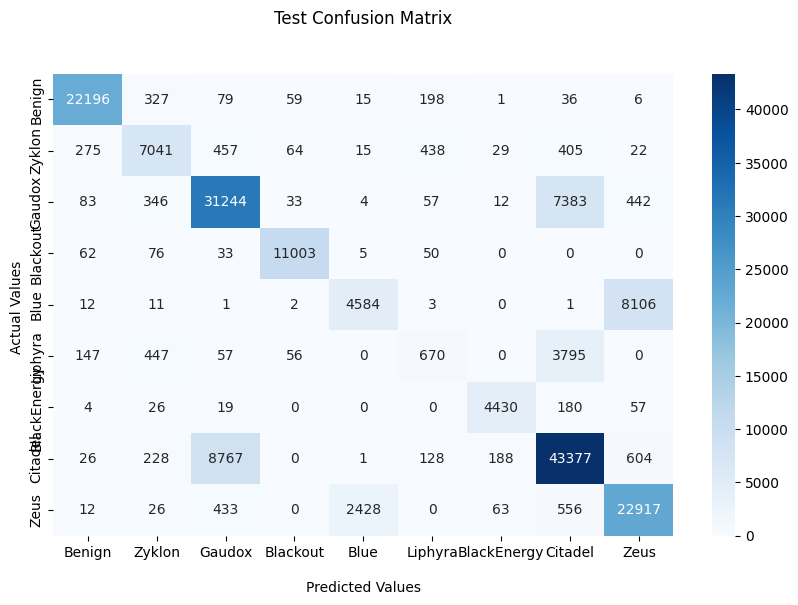

[CV] END .................................................... total time=   1.9s
[CV] END .................................................... total time=   1.9s


In [484]:
param_grid = {
    'max_depth': [30,50],
}

dtree = DecisionTreeClassifier()

perform_mc_grid_search(dtree, param_grid, df_X_mc, df_y_mc)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'max_depth': 30}
Train Accuracy = 0.8690329665025581
Test Accuracy = 0.651212055708242


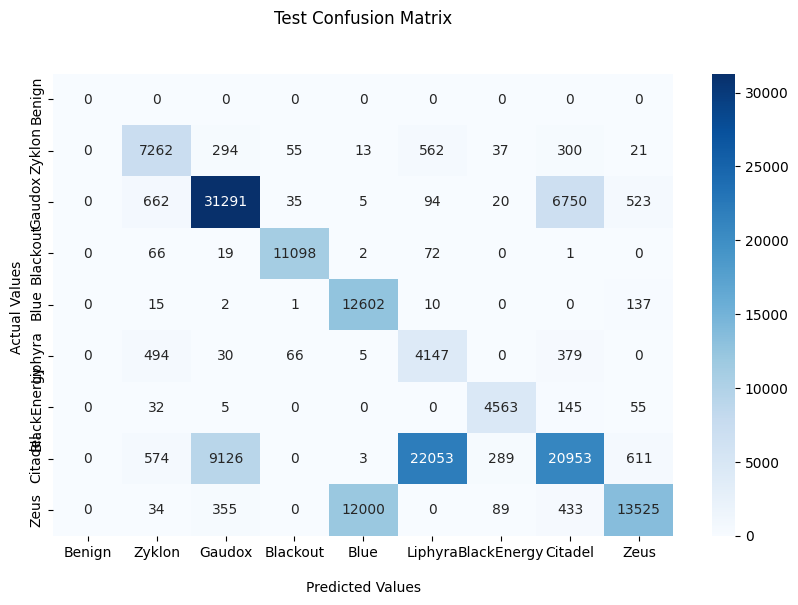

[CV] END .......................................max_depth=30; total time=  34.4s
[CV] END .......................................max_depth=50; total time=  33.8s
[CV] END .......................................max_depth=50; total time=  35.3s
[CV] END .......................................max_depth=30; total time=  36.8s
[CV] END .......................................max_depth=30; total time=  36.5s
[CV] END .......................................max_depth=30; total time=  37.0s
[CV] END .......................................max_depth=30; total time=  37.4s
[CV] END .......................................max_depth=50; total time=  35.6s
[CV] END .......................................max_depth=50; total time=  35.9s
[CV] END .......................................max_depth=50; total time=  36.2s


In [472]:
param_grid = {
    'max_depth': [30,50],
}

dtree = DecisionTreeClassifier()

perform_mc_grid_search(dtree, param_grid, df_X_mc, df_y_mc, only_malicious=True, smote=True)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END .......................................max_depth=50; total time=  14.9s
[CV] END .......................................max_depth=30; total time=  41.2s
[CV] END .......................................max_depth=50; total time=  14.9s
[CV] END .......................................max_depth=30; total time=  41.1s
[CV] END .......................................max_depth=50; total time=  14.8s
[CV] END .......................................max_depth=50; total time=  41.6s
[CV] END .......................................max_depth=30; total time=  14.6s
[CV] END .......................................max_depth=30; total time=  42.7s
[CV] END .......................................max_depth=50; total time=  14.9s
[CV] END .......................................max_depth=50; total time=  41.0s
[CV] END .......................................max_depth=30; total time=  14.4s
[CV] END .......................................m

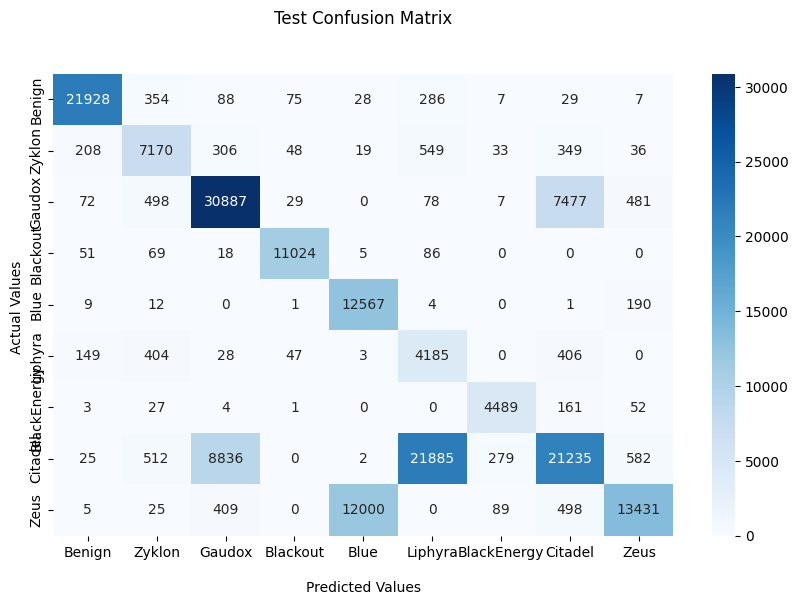

In [397]:
param_grid = {
    'max_depth': [30,50],
}

dtree = DecisionTreeClassifier()

perform_mc_grid_search(dtree, param_grid, df_X_mc, df_y_mc, smote=True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .......................................max_depth=50; total time=  41.1s
[CV] END .......................................max_depth=30; total time=  13.6s
Best Parameters: {'max_depth': 30}
Train Accuracy = 0.7694738428367742
Test Accuracy = 0.6891289530342208


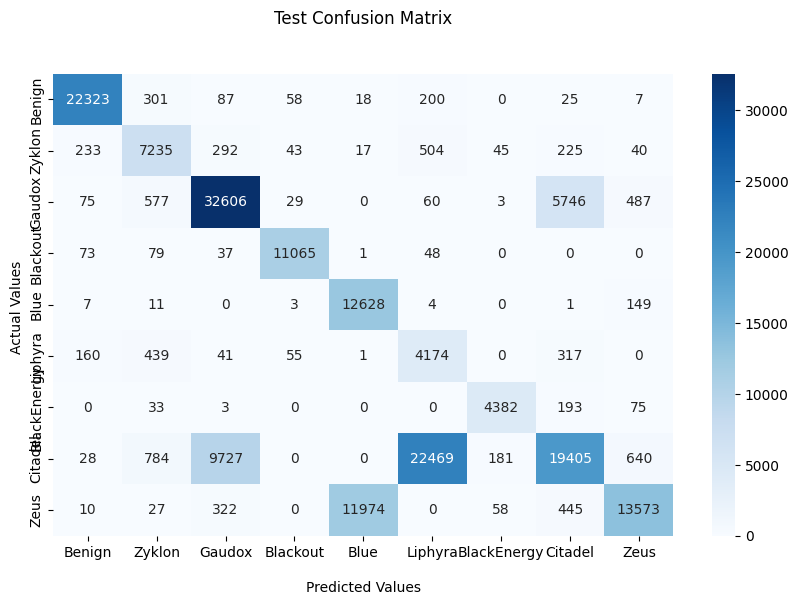

In [398]:
param_grid = {
    'max_depth': [30],
}

dtree = DecisionTreeClassifier(class_weight='balanced')

perform_mc_grid_search(dtree, param_grid, df_X_mc, df_y_mc)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .......................................max_depth=30; total time=   9.5s
[CV] END .......................................max_depth=30; total time=  11.0s
[CV] END .......................max_depth=5, n_estimators=50; total time= 1.0min
[CV] END ......................max_depth=30, n_estimators=50; total time= 2.4min
[CV] END .......................................max_depth=30; total time=  11.2s
[CV] END .......................................max_depth=30; total time=  14.9s
[CV] END ......................max_depth=10, n_estimators=50; total time= 1.6min
[CV] END ......................max_depth=30, n_estimators=50; total time= 2.3min
[CV] END .......................................max_depth=30; total time=   9.8s
[CV] END .......................................max_depth=30; total time=  11.2s
[CV] END ......................max_depth=10, n_estimators=50; total time= 1.6min
[CV] END ......................max_depth=30, n_es

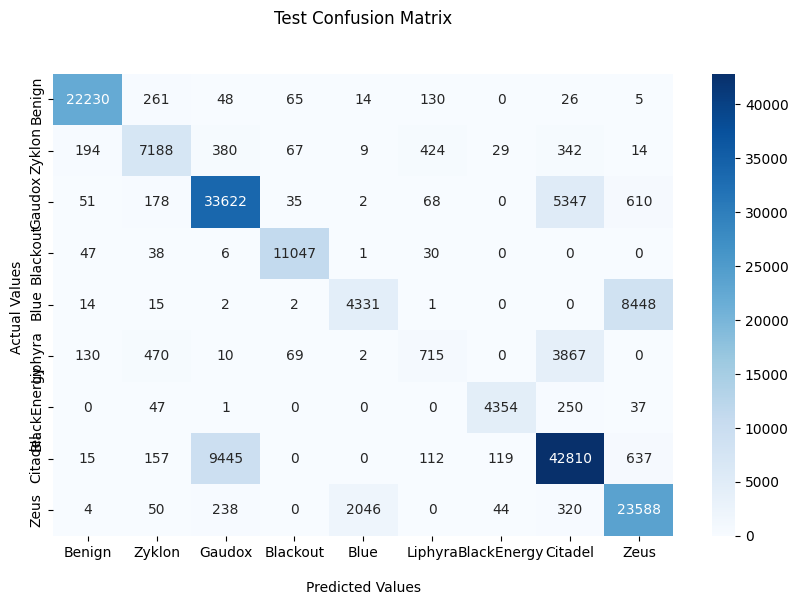

[CV] END .....................max_depth=10, n_estimators=100; total time= 3.1min


In [317]:
param_grid = {
    'max_depth': [5, 10, 30],
    'n_estimators': [50, 100],
}


rforest = RandomForestClassifier()

perform_mc_grid_search(rforest, param_grid, df_X_mc, df_y_mc)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .......................................max_depth=30; total time=  14.5s
[CV] END .......................................max_depth=30; total time=  41.9s
[CV] END .......................................max_depth=50; total time=  14.7s
[CV] END .......................................max_depth=30; total time=  12.7s
[CV] END .......................................max_depth=30; total time=  14.5s
[CV] END .......................................max_depth=30; total time=  13.3s
[CV] END .......................................max_depth=30; total time=  13.2s
[CV] END .......................................max_depth=30; total time=  13.3s
[CV] END .......................................max_depth=30; total time=  41.6s
[CV] END .....................max_depth=30, n_estimators=100; total time= 4.6min
[CV] END .....................max_depth=30, n_estimators=100; total time= 4.5min
[CV] END .....................max_depth=30, n_esti

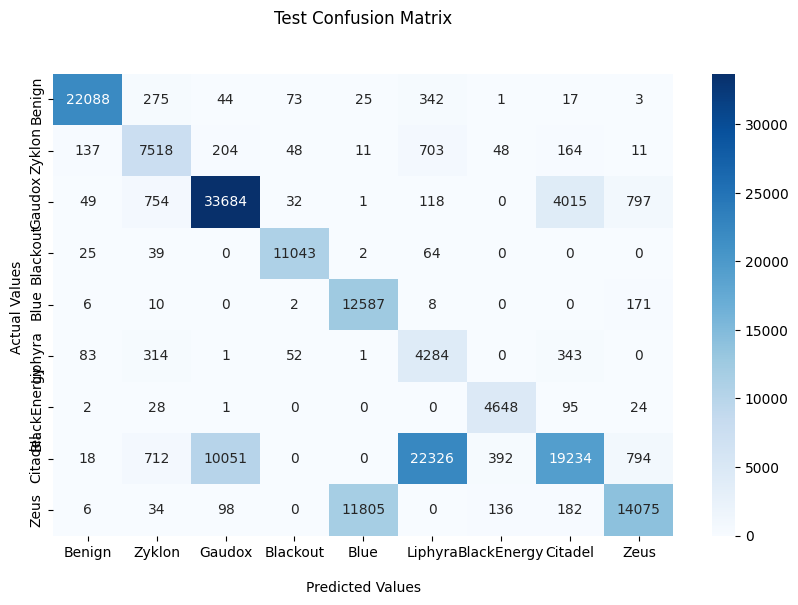

In [399]:
param_grid = {
    'max_depth': [30],
    'n_estimators': [100],
}


rforest = RandomForestClassifier()

perform_mc_grid_search(rforest, param_grid, df_X_mc, df_y_mc, smote=True)

## Keras

In [485]:
# Normalize data (not for decision tree and random forest)
scaler = StandardScaler()
df_X_mc_scaled = scaler.fit_transform(df_X_mc[df_X_mc.columns[:-3]])

df_X_mc_scaled = pd.DataFrame(df_X_mc_scaled, columns=df_X_mc.columns[:-3])
df_X_mc_scaled[df_X_mc.columns[-3:]] = df_X_mc[df_X_mc.columns[-3:]]
df_X_mc_scaled.head()

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Protocol_0,Protocol_6,Protocol_17
0,-0.197223,-0.178273,0.061675,-0.256793,-0.012647,0.453814,0.466711,0.464425,-0.046834,-0.276854,...,-0.061106,-0.14495,-0.16014,-0.205001,-0.088995,-0.207219,-0.195185,False,False,True
1,2.427070,0.098283,-0.459456,1.086011,-0.006000,3.311558,3.383699,3.373460,-0.046834,0.047440,...,-0.061106,-0.14495,-0.16014,2.993699,-0.085403,2.569671,3.202846,False,False,True
2,0.084537,0.651396,0.061675,0.504711,-0.011539,0.601121,0.617071,0.614375,-0.046834,-0.260138,...,-0.061106,-0.14495,-0.16014,-0.205001,-0.088995,-0.207219,-0.195185,False,False,True
3,-0.009236,0.651396,-0.459456,0.551215,-0.015971,0.660043,0.677215,0.674355,-0.046834,-0.253452,...,-0.061106,-0.14495,-0.16014,-0.205001,-0.088995,-0.207219,-0.195185,False,False,True
4,0.084535,0.098283,0.061675,0.039670,-0.011096,0.660043,0.677215,0.674355,-0.046834,-0.253452,...,-0.061106,-0.14495,-0.16014,-0.205001,-0.088995,-0.207219,-0.195185,False,False,True


In [537]:
X_train, X_test, y_train, y_test = train_test_split(df_X_mc_scaled, df_y_mc, test_size=0.3)

In [365]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

model = Sequential()
model.add(Dense(64, input_dim=79, activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))
#model.add(Dense(32, activation='relu'))
model.add(Dense(9, activation='softmax'))

In [538]:
y_train_enc = pd.get_dummies(y_train)
y_train_enc

,Benign,BlackEnergy,Blackout,Blue,Citadel,Gaudox,Liphyra,Zeus,Zyklon
143191,False,False,False,False,False,False,True,False,False
480316,False,False,False,False,False,True,False,False,False
13904,True,False,False,False,False,False,False,False,False
605722,False,False,False,False,False,False,False,True,False
2484,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
509432,False,False,False,False,True,False,False,False,False
76757,False,False,False,False,False,True,False,False,False
155309,False,False,False,True,False,False,False,False,False
222609,False,False,False,False,False,True,False,False,False


In [539]:
X_train_enc = X_train.astype('float32').to_numpy()
X_train_enc

array([[-0.38384217, -0.45482928,  0.06167462, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.0845358 ,  0.09828314,  0.06167462, ...,  0.        ,
         0.        ,  1.        ],
       [ 5.236391  ,  0.65139556, -0.45945626, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.38383955, -0.45482928,  0.06167462, ...,  0.        ,
         0.        ,  1.        ],
       [-0.10291978,  0.9279518 , -0.45945626, ...,  0.        ,
         0.        ,  1.        ],
       [-0.38384417, -0.45482928,  0.06167462, ...,  0.        ,
         0.        ,  1.        ]], dtype=float32)

In [368]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_enc, y_train_enc, epochs=10, batch_size=32)

Epoch 1/10
13480/13480 [==============================] - 22s 2ms/step - loss: 0.1703 - accuracy: 0.6368
Epoch 2/10
13480/13480 [==============================] - 20s 2ms/step - loss: 0.1300 - accuracy: 0.7183
Epoch 3/10
13480/13480 [==============================] - 23s 2ms/step - loss: 0.1233 - accuracy: 0.7268
Epoch 4/10
13480/13480 [==============================] - 22s 2ms/step - loss: 0.1202 - accuracy: 0.7298
Epoch 5/10
13480/13480 [==============================] - 21s 2ms/step - loss: 0.1184 - accuracy: 0.7337
Epoch 6/10
13480/13480 [==============================] - 20s 2ms/step - loss: 0.1173 - accuracy: 0.7359
Epoch 7/10
13480/13480 [==============================] - 21s 2ms/step - loss: 0.1179 - accuracy: 0.7344
Epoch 8/10
13480/13480 [==============================] - 21s 2ms/step - loss: 0.1167 - accuracy: 0.7358
Epoch 9/10
13480/13480 [==============================] - 21s 2ms/step - loss: 0.1167 - accuracy: 0.7365
Epoch 10/10
13480/13480 [==============================

In [369]:
loss, accuracy = model.evaluate(X_test.astype('float32').to_numpy(), pd.get_dummies(y_test))
print(f"Test Accuracy: {accuracy*100:.2f}%")

5777/5777 [==============================] - 8s 1ms/step - loss: 0.1077 - accuracy: 0.7524
Test Accuracy: 75.24%


## XGBoost

In [540]:
import xgboost as xgb

In [507]:
clf = xgb.XGBClassifier(objective='multi:softmax', num_class=9, eval_metric='mlogloss',max_depth=8)

encoder = LabelEncoder()

# Training the model
clf.fit(X_train_enc, encoder.fit_transform(y_train))

# Evaluating the model
print(f"training accuracy:{clf.score(X_train_enc, encoder.transform(y_train))}")
print(f"test accuracy: {clf.score(X_test.astype('float32').to_numpy(), encoder.transform(y_test))}")

training accuracy:0.838042356868791
test accuracy: 0.8165835397981153


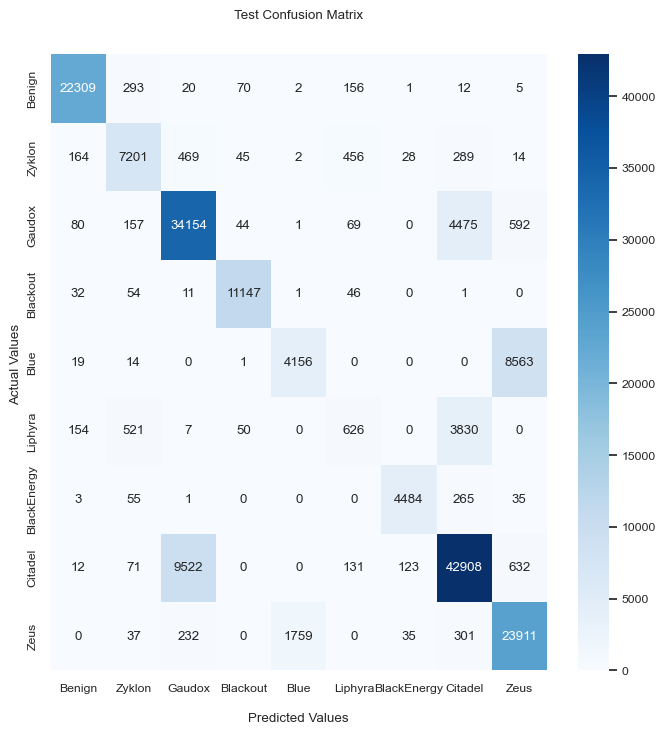

              precision    recall  f1-score   support

      Benign       0.98      0.98      0.98     22868
 BlackEnergy       0.96      0.93      0.94      4843
    Blackout       0.98      0.99      0.98     11292
        Blue       0.70      0.33      0.45     12753
     Citadel       0.82      0.80      0.81     53399
      Gaudox       0.77      0.86      0.81     39572
     Liphyra       0.42      0.12      0.19      5188
        Zeus       0.71      0.91      0.80     26275
      Zyklon       0.86      0.83      0.84      8668

    accuracy                           0.82    184858
   macro avg       0.80      0.75      0.76    184858
weighted avg       0.81      0.82      0.80    184858



In [564]:
unique_labels = ['Benign', 'Zyklon', 'Gaudox', 'Blackout', 'Blue', 'Liphyra','BlackEnergy', 'Citadel', 'Zeus']

y_test_pred = encoder.inverse_transform(clf.predict(X_test.astype('float32').to_numpy()))

cm = confusion_matrix(y_test, y_test_pred, labels=unique_labels)    
plt.figure(figsize=(8,8))
sb.set(font_scale=0.8)
ax = sb.heatmap(cm, annot=True, cmap="Blues", fmt='d')
ax.set_title("Test Confusion Matrix\n\n")
ax.set_xlabel("\nPredicted Values")
ax.set_ylabel("Actual Values ")
ax.xaxis.set_ticklabels(unique_labels)
ax.yaxis.set_ticklabels(unique_labels)
plt.show()

print(classification_report(y_test, y_test_pred))#, target_names=unique_labels))

In [ ]:
smote = SMOTE()
df_X_mc_smote, df_y_mc_smote = smote.fit_resample(df_X_mc, df_y_mc)

clf = xgb.XGBClassifier(objective='multi:softmax', num_class=9, eval_metric='mlogloss',max_depth=6)

encoder = LabelEncoder()

# Training the model
clf.fit(X_train_enc, encoder.fit_transform(y_train))

# Evaluating the model
print(f"training accuracy:{clf.score(X_train_enc, encoder.transform(y_train))}")
print(f"test accuracy: {clf.score(X_test.astype('float32').to_numpy(), encoder.transform(y_test))}")

## Binary before Multiclass Classifier

In [511]:
X_train, X_test, y_botnet_train, y_botnet_test = train_test_split(df_X_mc, df_y_mc, test_size=0.3)

y_binary_train = y_botnet_train.apply(lambda x: 'Malicious' if x != 'Benign' else 'Benign')
y_binary_test = y_botnet_test.apply(lambda x: 'Malicious' if x != 'Benign' else 'Benign')

# Training the first classifier
clf_binary = RandomForestClassifier(max_depth=30)
clf_binary.fit(X_train, y_binary_train)
malicious_indices = (clf_binary.predict(X_train) == 'Malicious')

# Training the second classifier (only on malicious entries)
clf_botnet = RandomForestClassifier(max_depth=30)
clf_botnet.fit(X_train[malicious_indices], y_botnet_train[malicious_indices])

# Predicting on the test set
y_binary_pred = clf_binary.predict(X_test)
print(accuracy_score(y_binary_pred,y_binary_test))

y_botnet_pred = clf_botnet.predict(X_test)

y_test_pred = []

for i, entry in enumerate(y_binary_pred):
    if entry == 'Benign':
        y_test_pred.append('Benign')
    else:
        y_test_pred.append(y_botnet_pred[i])

0.9945363468175573


In [512]:
print(f"Test Accuracy = {accuracy_score(y_test_pred, y_botnet_test)}")

Test Accuracy = 0.8106871220071623
